## Imports

In [ ]:
import pandas as pd
import numpy as np
import re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import spacy
import string

from google.colab import drive
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score

warnings.filterwarnings("ignore")
nltk.download('all')
pd.options.mode.chained_assignment = None

## Gdrive

In [ ]:
drive.mount('/content/gdrive/', force_remount=True)

## Data Filtering

In [ ]:
df = pd.read_csv("/content/gdrive/MyDrive/Train.csv")

print("Original dataset shape = ", df.shape)
df.head()

Original dataset shape =  (6034195, 4)


,Id,Title,Body,Tags
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding
4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents


In [ ]:
duplicate_pairs = df.sort_values('Title', ascending=False).duplicated('Title')
print("Total number of duplicate questions : ", duplicate_pairs.sum())
df = df[~duplicate_pairs]
print("Dataframe shape after duplicate removal : ", df.shape)

Total number of duplicate questions :  1908962
Dataframe shape after duplicate removal :  (4125233, 4)


In [ ]:
df["Tags"] = df["Tags"].astype(str)

In [ ]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
tag_bow = vectorizer.fit_transform(df['Tags'])

In [ ]:
print("Number of questions   :", tag_bow.shape[0])
print("Number of unique tags :", tag_bow.shape[1])

In [ ]:
tags = vectorizer.get_feature_names()
print("Few tags :", tags[:10])

Few tags : ['.a', '.app', '.asp.net-mvc', '.aspxauth', '.bash-profile', '.class-file', '.cs-file', '.doc', '.drv', '.ds-store']


In [ ]:
freq = tag_bow.sum(axis=0).A1
tag_to_count_map = dict(zip(tags, freq))

In [ ]:
list = []
for key, value in tag_to_count_map.items():
  list.append([key, value]) 

print(list)

[['.a', 18], ['.app', 35], ['.asp.net-mvc', 1], ['.aspxauth', 21], ['.bash-profile', 136], ['.class-file', 53], ['.cs-file', 13], ['.doc', 46], ['.drv', 1], ['.ds-store', 8], ['.each', 183], ['.emf', 33], ['.exe', 18], ['.exe.config', 1], ['.hgtags', 6], ['.htaccess', 14521], ['.htpasswd', 59], ['.ico', 9], ['.lib', 20], ['.lrc', 4], ['.mobi', 2], ['.mov', 16], ['.net', 112555], ['.net-1.0', 19], ['.net-1.1', 217], ['.net-2.0', 1642], ['.net-3.0', 52], ['.net-3.5', 3655], ['.net-4.0', 4942], ['.net-4.0-beta-2', 16], ['.net-4.0-rc1', 6], ['.net-4.5', 685], ['.net-assembly', 515], ['.net-authorization', 2], ['.net-bcl', 2], ['.net-bugs', 1], ['.net-cf-3.5', 61], ['.net-client-profile', 53], ['.net-compact', 1], ['.net-framework', 227], ['.net-framework-source', 15], ['.net-framework-version', 72], ['.net-gadgeteer', 12], ['.net-install', 6], ['.net-internals', 4], ['.net-interview', 3], ['.net-micro-framework', 102], ['.net-reflector', 24], ['.net-remoting', 125], ['.net-security', 13], 

In [ ]:
tag_df = pd.DataFrame(list, columns=['Tags', 'Counts'])
print(tag_df.shape)
tag_df.head()

(41579, 2)


,Tags,Counts
0,.a,18
1,.app,35
2,.asp.net-mvc,1
3,.aspxauth,21
4,.bash-profile,136


Text(0, 0.5, 'Frequency')

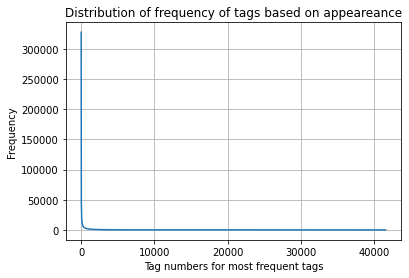

In [ ]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
plt.plot(tag_df_sorted['Counts'].values)
plt.grid()
plt.title("Distribution of frequency of tags based on appeareance")
plt.xlabel("Tag numbers for most frequent tags")
plt.ylabel("Frequency")

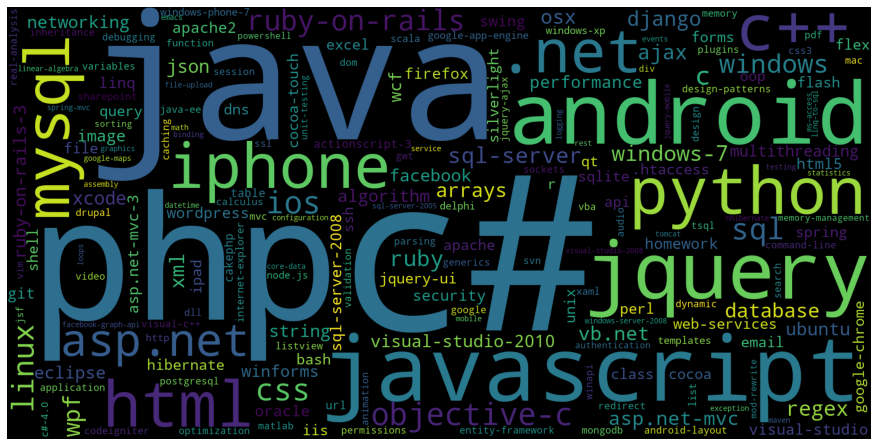

In [ ]:
tupl = dict(tag_to_count_map.items())
word_cloud = WordCloud(width=1600, height=800).generate_from_frequencies(tupl)
plt.figure(figsize = (12,8))
plt.imshow(word_cloud)
plt.axis('off')
plt.tight_layout(pad=0)

In [ ]:
top10_tags = tag_df_sorted[:10].Tags
top10_tags = top10_tags.tolist()

In [ ]:
for i, row in df.iterrows():
  t = ""
  for j in row['Tags'].split():
    if j in top10_tags:
      t = t + " " + j
  df.at[i, 'Tags'] = t 

In [ ]:
df['Tags'].replace('', np.nan, inplace=True)
print("Before removing nan = ", df.shape)
df.dropna(subset=['Tags'], inplace=True)
print("After removing nan = ", df.shape)
# df = df.drop(['tag_count'], axis=1)
df

Before removing nan =  (1898097, 4)
After removing nan =  (1898097, 4)


,Id,Title,Body,Tags
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c#
7,8,How to fetch an XML feed using asp.net,<p>I've decided to convert a Windows Phone 7 a...,c# asp.net
15,16,PHP framework URL conventions,<p>A lot of frameworks use URL conventions lik...,php
18,19,Play framework auto javascript and CSS minifier,<p>Does anyone know a good play plugin that au...,javascript
...,...,...,...,...
6034176,6034177,Need help with friendly URL's in Wordpress,<p>I'm creating som custom templates in Wordpr...,php
6034181,6034182,Bitwise subtraction,<p>Given the enum:</p>\n\n<pre><code>[Flags]\n...,c#
6034191,6034192,Javascript resize on every image load,<p>I've got this code:</p>\n\n<pre><code>while...,php javascript
6034192,6034193,Update database with big CSV,<p>I need every day update ~ 10.000 items in m...,php


In [ ]:
df.to_csv('/content/gdrive/MyDrive/uottawa/nlp/train_top_10.csv')

## Data Loading

In [ ]:
df = pd.read_csv("/content/gdrive/MyDrive/uottawa/nlp/train_top_10.csv")
print("Dataset shape = ", df.shape)
df = df.drop(["Unnamed: 0", 'Id'], axis=1)
df.head()

Dataset shape =  (1898097, 5)


,Title,Body,Tags
0,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php
1,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c#
2,How to fetch an XML feed using asp.net,<p>I've decided to convert a Windows Phone 7 a...,c# asp.net
3,PHP framework URL conventions,<p>A lot of frameworks use URL conventions lik...,php
4,Play framework auto javascript and CSS minifier,<p>Does anyone know a good play plugin that au...,javascript


In [ ]:
df["Tags"] = df["Tags"].astype(str)

## Data Summarization

In [ ]:
df["tag_count"] = df["Tags"].apply(lambda x : len(x.split()))
df.head()

,Title,Body,Tags,tag_count
0,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php,1
1,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c#,1
2,How to fetch an XML feed using asp.net,<p>I've decided to convert a Windows Phone 7 a...,c# asp.net,2
3,PHP framework URL conventions,<p>A lot of frameworks use URL conventions lik...,php,1
4,Play framework auto javascript and CSS minifier,<p>Does anyone know a good play plugin that au...,javascript,1


In [ ]:
# how many rows with 'n' tags
df["tag_count"].value_counts()

1    1672995
2     211393
3      13100
4        598
5         11
Name: tag_count, dtype: int64

Text(0, 0.5, 'Frequency')

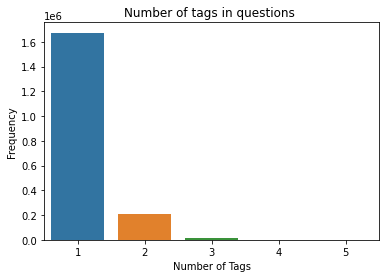

In [ ]:
# distribution of tweets
sns.countplot(df["tag_count"])
plt.title("Number of tags in questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Frequency")

In [ ]:
print( "Maximum number of tags in a question: ", df["tag_count"].max())
print( "Minimum number of tags in a question: ", df["tag_count"].min())
print( "Average number of tags in a question: ", df["tag_count"].mean())

Maximum number of tags in a question:  5
Minimum number of tags in a question:  1
Average number of tags in a question:  1.1261426576197107


In [ ]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
tag_bow = vectorizer.fit_transform(df['Tags'])

In [ ]:
print("Number of questions   :", tag_bow.shape[0])
print("Number of unique tags :", tag_bow.shape[1])

In [ ]:
tags = vectorizer.get_feature_names()
print("Few tags :", tags[:10])

Few tags : ['.a', '.app', '.asp.net-mvc', '.aspxauth', '.bash-profile', '.class-file', '.cs-file', '.doc', '.drv', '.ds-store']


In [ ]:
freq = tag_bow.sum(axis=0).A1
tag_to_count_map = dict(zip(vectorizer.get_feature_names(), freq))

In [ ]:
list = []
tags_list = []
for key, value in tag_to_count_map.items():
  tags_list.append(key)
  list.append([key, value]) 

print(tags_list)

['android', 'asp.net', 'c#', 'c++', 'iphone', 'java', 'javascript', 'jquery', 'php', 'python']


In [ ]:
tag_df = pd.DataFrame(list, columns=['Tags', 'Counts'])
print(tag_df.shape)
tag_df.head()

(10, 2)


,Tags,Counts
0,android,232412
1,asp.net,123771
2,c#,327237
3,c++,141608
4,iphone,127132


Text(0, 0.5, 'Frequency')

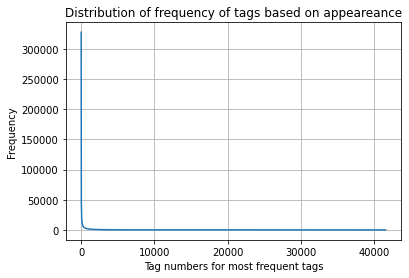

In [ ]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
plt.plot(tag_df_sorted['Counts'].values)
plt.grid()
plt.title("Distribution of frequency of tags based on appeareance")
plt.xlabel("Tag numbers for most frequent tags")
plt.ylabel("Frequency")

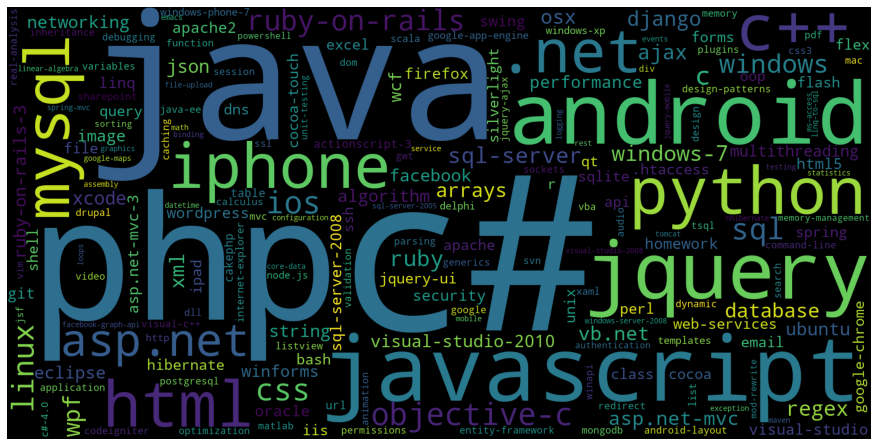

In [ ]:
tupl = dict(tag_to_count_map.items())
word_cloud = WordCloud(width=1600, height=800).generate_from_frequencies(tupl)
plt.figure(figsize = (12,8))
plt.imshow(word_cloud)
plt.axis('off')
plt.tight_layout(pad=0)

## Data Preprocessing

In [ ]:
def getDescription(body):
  return re.sub('<code>(.*?)</code>', '', body, flags=re.MULTILINE|re.DOTALL)

In [ ]:
def getCode(body):
  str1 = re.search('<code>(.*?)</code>', body, flags=0)
  if(str1 == None): 
    return ""
  else: 
    return str1.group(1)

In [ ]:
# separate code from body
df["description"] = df.apply(lambda row: getDescription(row["Body"]), axis = 1)
df["code"] = df.apply(lambda row: getCode(row["Body"]), axis = 1)
df = df.drop(["Body"], axis=1)
df.head()

,Title,Tags,tag_count,description,code
0,How to check if an uploaded file is an image w...,php,1,<p>I'd like to check if an uploaded file is an...,
1,How do I replace special characters in a URL?,c#,1,"<p>This is probably very simple, but I simply ...",
2,How to fetch an XML feed using asp.net,c# asp.net,2,<p>I've decided to convert a Windows Phone 7 a...,
3,PHP framework URL conventions,php,1,<p>A lot of frameworks use URL conventions lik...,/controller/action/{id}
4,Play framework auto javascript and CSS minifier,javascript,1,<p>Does anyone know a good play plugin that au...,


In [ ]:
url_pattern = re.compile(r'https?://\S+|www\.\S+')
html_pattern = re.compile('<.*?>')
pattern = re.compile(r'[^a-z]+')

In [ ]:
def preProcessing(text):
  # remove urls
  text = url_pattern.sub(r'', text)
  # remove html tags
  text = html_pattern.sub(r'', text)
  # remove stopwords
  text = " ".join([word for word in str(text).split() if word not in set(stopwords.words('english'))])
  # remove punctuations
  text = text.translate(str.maketrans('', '', string.punctuation))
  # lower the text
  text = text.lower()
  # remove unnecessary spaces
  text = re.sub(r'\s+',' ', text)
  # remove non alphabetic sequences
  text = pattern.sub(' ', text).strip()
  # stemming
  # ps  = PorterStemmer()
  # word_list = [ps.stem(word) for word in word_tokenize(text) if word not in set(tags_list)]
  # text = ' '.join(word_list)
  return text

In [ ]:
df["Title"] = df.apply(lambda row: preProcessing(row["Title"]), axis = 1)
df["description"] = df.apply(lambda row: preProcessing(row["description"]), axis = 1)
df

,Title,Tags,tag_count,description,code
0,how check uploaded file image without mime type,php,1,id like check uploaded file image file eg png ...,
1,how i replace special characters url,c#,1,this probably simple i simply cannot find answ...,
2,how fetch xml feed using aspnet,c# asp.net,2,ive decided convert windows phone app fetches ...,
3,php framework url conventions,php,1,a lot frameworks use url conventions like grea...,/controller/action/{id}
4,play framework auto javascript css minifier,javascript,1,does anyone know good play plugin automaticall...,
...,...,...,...,...,...
1898092,need help friendly urls wordpress,php,1,im creating som custom templates wordpress im ...,/%category%/%postname%/
1898093,bitwise subtraction,c#,1,given enum if i know foo contains previously i...,c
1898094,javascript resize every image load,php javascript,2,ive got code i want resize function called eve...,
1898095,update database big csv,php,1,i need every day update items mysql i upload c...,


In [ ]:
df.to_csv('/content/gdrive/MyDrive/uottawa/nlp/train_top_10_pp.csv')

## Preprocessed data loading

In [12]:
df = pd.read_csv("/content/gdrive/MyDrive/train_top_10_pp.csv")
df.head()

,Unnamed: 0,Title,Tags,tag_count,description,code
0,0,how check uploaded file image without mime type,php,1,id like check uploaded file image file eg png ...,NaN
1,1,how i replace special characters url,c#,1,this probably simple i simply cannot find answ...,NaN
2,2,how fetch xml feed using aspnet,c# asp.net,2,ive decided convert windows phone app fetches ...,NaN
3,3,php framework url conventions,php,1,a lot frameworks use url conventions like grea...,/controller/action/{id}
4,4,play framework auto javascript css minifier,javascript,1,does anyone know good play plugin automaticall...,NaN


In [13]:
print(df.shape)

df["code"] = df["code"].fillna("")
df["description"] = df["description"].fillna("")
df = df[df['Title'].notna()]
print(df.shape)

(1898097, 6)
(1898077, 6)


## OneVsRest Classifier

In [ ]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
y_multilabel = vectorizer.fit_transform(df['Tags'])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df, y_multilabel, test_size = 0.2, random_state = 42)

print("Number of data points in training data :", x_train.shape[0])
print("Number of data points in test data :", x_test.shape[0])

Number of data points in training data : 1518461
Number of data points in test data : 379616


In [ ]:
vectorizer = TfidfVectorizer(tokenizer = lambda x: x.split(), ngram_range=(1,3))

x_train_multilabel = vectorizer.fit_transform(x_train["Title"])
x_test_multilabel = vectorizer.transform(x_test["Title"])

In [ ]:
print("Training data shape X : ", x_train_multilabel.shape, "Y :", y_train.shape)
print("Test data shape X : ", x_test_multilabel.shape, "Y:", y_test.shape)

Training data shape X :  (1518461, 7183485) Y : (1518461, 10)
Test data shape X :  (379616, 7183485) Y: (379616, 10)


In [ ]:
clf = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l2'))
clf.fit(x_train_multilabel, y_train)

OneVsRestClassifier(estimator=SGDClassifier(alpha=1e-05, loss='log'))

In [ ]:
y_pred = clf.predict(x_test_multilabel)

In [ ]:
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))
print("Macro f1 score: ", metrics.f1_score(y_test, y_pred, average = 'macro'))
print("Micro f1 scoore: ", metrics.f1_score(y_test, y_pred, average = 'micro'))
print("Hamming loss: ", metrics.hamming_loss(y_test, y_pred))

Accuracy:  0.446056014498862
Macro f1 score:  0.6302642455538349
Micro f1 scoore:  0.6347788503097536
Hamming loss:  0.06410688695945377


##Final LSTM model

In [7]:
# mlp for multi-label classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import RepeatedKFold
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score

In [67]:
new_df = df.sample(n=500000)

In [68]:
new_df.head()

,Unnamed: 0,Title,Tags,tag_count,description,code
185547,185547,might pyglet vertex lists batches slow windows,python,1,im writing opengl code python using library py...,
514640,514640,ifelse good design,c#,1,is acceptablegoodstyle simplify function as th...,
1113063,1113063,special characters xml encoding using dom java,java,1,i code transform excel file xml one cells text...,
1322115,1322115,loading jquery background slider using ajax,jquery,1,i need create website propagates internal link...,
109672,109672,do anyone know im getting null exception error,c#,1,i keep getting null exception i instantiated m...,


In [69]:
from sklearn.preprocessing import MultiLabelBinarizer

In [70]:
new_df['Tags'] = new_df.apply(lambda row: row["Tags"].strip().split(' '), axis=1)

In [71]:
new_df.head()

,Unnamed: 0,Title,Tags,tag_count,description,code
185547,185547,might pyglet vertex lists batches slow windows,[python],1,im writing opengl code python using library py...,
514640,514640,ifelse good design,[c#],1,is acceptablegoodstyle simplify function as th...,
1113063,1113063,special characters xml encoding using dom java,[java],1,i code transform excel file xml one cells text...,
1322115,1322115,loading jquery background slider using ajax,[jquery],1,i need create website propagates internal link...,
109672,109672,do anyone know im getting null exception error,[c#],1,i keep getting null exception i instantiated m...,


In [72]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(new_df['Tags'])

y = multilabel_binarizer.transform(new_df['Tags'])
y, y.shape

(array([[0, 0, 0, ..., 0, 0, 1],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]), (500000, 10))

In [73]:
x_train, x_test, y_train, y_test = train_test_split(new_df, y, test_size=0.2)
x_train = x_train.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
x_train.shape, x_test.shape

((400000, 6), (100000, 6))

In [74]:
y_test.shape

(100000, 10)

In [75]:
train_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<OOV>')
train_tokenizer.fit_on_texts(x_train['Title'].values)
train_word_index = train_tokenizer.word_index

In [76]:
vocab_length = len(train_word_index) + 1
vocab_length

84004

In [77]:
train_sequences = train_tokenizer.texts_to_sequences(x_train['Title'].values)
len(train_sequences)

400000

In [78]:
test_sequences = train_tokenizer.texts_to_sequences(x_test['Title'].values)
len(test_sequences)

100000

In [79]:
longest_sentence = len(max(train_sequences, key=len))
train_padded_seqeunces = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, padding='post', maxlen=longest_sentence, truncating='post')
test_padded_seqeunces = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, padding='post', maxlen=longest_sentence, truncating='post')
longest_sentence

23

In [80]:
# removes all nodes left over from previous models added to the graph
tf.keras.backend.clear_session()

# dimension to which each word in training set will get encoded
embedding_dim = 50

model = tf.keras.Sequential([
    # convert words into dense vectors
    tf.keras.layers.Embedding(vocab_length, embedding_dim, input_length=longest_sentence),
    # 1 in 2 inputs are excluded during training
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.LSTM(100, return_sequences=True),
    # 1 in 5 inputs are excluded during training
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(50, return_sequences=True),
    # 1 in 5 inputs are excluded during training
    tf.keras.layers.Dropout(0.2),
    # normalize output of above layers
    tf.keras.layers.BatchNormalization(),
    # downsampling using max of axis =1
    tf.keras.layers.GlobalMaxPooling1D(),
    # outputs 16 neurons after connecting with neurons in the previous layer's output (mat multi)
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(y.shape[1], activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 23, 50)            4200200   
                                                                 
 dropout (Dropout)           (None, 23, 50)            0         
                                                                 
 lstm (LSTM)                 (None, 23, 100)           60400     
                                                                 
 dropout_1 (Dropout)         (None, 23, 100)           0         
                                                                 
 batch_normalization (BatchN  (None, 23, 100)          400       
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 23, 50)            30200     
                                                        

In [82]:
history = model.fit(train_padded_seqeunces, y_train, epochs=10,
                    validation_data=(test_padded_seqeunces, y_test))

Epoch 1/10
12500/12500 [==============================] - 123s 10ms/step - loss: 0.1607 - accuracy: 0.6758 - val_loss: 0.1469 - val_accuracy: 0.7109
Epoch 2/10
12500/12500 [==============================] - 120s 10ms/step - loss: 0.1397 - accuracy: 0.7224 - val_loss: 0.1414 - val_accuracy: 0.7216
Epoch 3/10
12500/12500 [==============================] - 122s 10ms/step - loss: 0.1287 - accuracy: 0.7487 - val_loss: 0.1384 - val_accuracy: 0.7304
Epoch 4/10
12500/12500 [==============================] - 120s 10ms/step - loss: 0.1207 - accuracy: 0.7656 - val_loss: 0.1370 - val_accuracy: 0.7335
Epoch 5/10
12500/12500 [==============================] - 121s 10ms/step - loss: 0.1158 - accuracy: 0.7740 - val_loss: 0.1368 - val_accuracy: 0.7319
Epoch 6/10
12500/12500 [==============================] - 121s 10ms/step - loss: 0.1126 - accuracy: 0.7798 - val_loss: 0.1380 - val_accuracy: 0.7290
Epoch 7/10
12500/12500 [==============================] - 120s 10ms/step - loss: 0.1103 - accuracy: 0.7832

In [83]:
pred_prob = model.predict(test_padded_seqeunces)
t = 0.3
test_pred = (pred_prob >= t).astype(int)

3125/3125 [==============================] - 10s 3ms/step


In [84]:
test_pred

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 1, 0]])

In [85]:
y_test

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 0, 0]])

In [86]:
test_padded_seqeunces

array([[ 5069,  3020,  3538, ...,     0,     0,     0],
       [  529,    30,     7, ...,     0,     0,     0],
       [    5,   938,    46, ...,     0,     0,     0],
       ...,
       [ 2023,   154,   237, ...,     0,     0,     0],
       [   13,  1333,     0, ...,     0,     0,     0],
       [16439,  1330,   590, ...,     0,     0,     0]], dtype=int32)

In [87]:
Ycv = y_test
Ycv_pred = test_pred
print("Accuracy :",metrics.accuracy_score(Ycv,Ycv_pred))
print("f1 score macro :",metrics.f1_score(Ycv,Ycv_pred, average = 'macro'))
print("f1 scoore micro :",metrics.f1_score(Ycv,Ycv_pred, average = 'micro'))
print("Hamming loss :",metrics.hamming_loss(Ycv,Ycv_pred))

Accuracy : 0.61614
f1 score macro : 0.7485470901811414
f1 scoore micro : 0.7431694918135913
Hamming loss : 0.060424


In [88]:
for i in range(10):
    k = x_test.sample(1).index[0]
    print("Title: ", x_test['Title'][k])
    print("Actual Tag: ", multilabel_binarizer.inverse_transform(y_test[k].reshape(1, -1))[0])
    print("Predicted tag: ", multilabel_binarizer.inverse_transform(test_pred[k].reshape(1, -1))[0])
    print('\n')

Title:  fallback javascript
Actual Tag:  ('javascript',)
Predicted tag:  ('javascript',)


Title:  array index bounds exception
Actual Tag:  ('java',)
Predicted tag:  ('c#', 'java')


Title:  transparent images looks ugly devices less android
Actual Tag:  ('android',)
Predicted tag:  ('android',)


Title:  ria services custom class
Actual Tag:  ('c#',)
Predicted tag:  ('c#',)


Title:  java validate xml using xsd namespaces
Actual Tag:  ('java',)
Predicted tag:  ('java',)


Title:  set jtabbedpane width constant
Actual Tag:  ('java',)
Predicted tag:  ('java',)


Title:  can visual studio wait until i move line show problems
Actual Tag:  ('c#',)
Predicted tag:  ('c#', 'c++')


Title:  how get jquery datatables switch multiple dom tables
Actual Tag:  ('javascript', 'jquery')
Predicted tag:  ('javascript', 'jquery')


Title:  jquery wait ajax call continuing
Actual Tag:  ('javascript', 'jquery', 'php')
Predicted tag:  ('javascript', 'jquery')


Title:  copy data datagridview
Actual Tag:  